# Estimate scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from scipy.signal import savgol_filter

warnings.filterwarnings('ignore')

%matplotlib notebook

In [36]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load files:

In [37]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

#### Functions

In [5]:
def assoc_depth(Al, Pb, depth_obs1, depth_obs2):
    
    # find depths that are in common
    pAl = np.copy(Al)
    dPb = np.empty_like(depth_obs1)
    
    i=0
    for depth in depth_obs1:
        min_val  = np.argmin(np.abs(depth_obs2 - depth))
        if np.abs(depth_obs2[min_val] - depth) > 20:
            pAl[i]           = np.nan
            dPb[i]           = np.nan
        else:
            dPb[i]           = Pb[min_val]
        i+=1
        
    return dPb, pAl

In [6]:
particulate_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')

Relationships checked:
- dissolved Pb vs. particulate Al --- not really
- dissolved Pb vs. particulate P  --- kind of
- dissolved Pb vs. particulate Fe --- not really
- dissolved Pb vs. particulate V  --- nope
- dissolved Pb vs. particulate Mn --- nope
- dissolved Pb vs. particulate Ba --- nope

In [24]:
def pair_samples(stn_name, chunks=False, slope=False):
    
    if stn_name[0:3]=='CAA':
        number = int(stn_name[3])+3
    elif stn_name[0:2]=='CB':
        number = int(stn_name[2])+12
    else:
        number = int(stn_name[2])
        
    depth_column = 'Depth.'+str(number)
    
    particulate_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')
    dissolved_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

    #------------ load data at this station -------------------------------------------------
    # particulate
    stns   = particulate_data['GEOTR_STN'].astype('str')
    pAl    = particulate_data['Al (nmol/L)'].where(stns == stn_name).apply(pd.to_numeric, errors='coerce').dropna().astype('float')
    pdep   = particulate_data['CTDPRS (DBAR)'].where(stns == stn_name).dropna().astype('float')
    pdepth = [pdep[i] for i in pAl.index.values]
    
    # dissolved
    dPb    = dissolved_data[stn_name][np.isfinite(Pb_data[stn_name])].astype('float')
    ddepth = dissolved_data[depth_column][np.isfinite(Pb_data[stn_name])].astype('float') ## fix: depth index
    
    #------------ compare depths ------------------------------------------------------------
    dPb_match, pAl_match = assoc_depth(pAl, dPb, pdepth, ddepth)
    
    ddepth = np.array(ddepth); pdepth = np.array(pdepth);
    
    if chunks:
        # Estimate the drop over chunks of depth:
        chunk      = 30
        try:
            num_chunks = np.int(np.floor(np.divide(np.min([np.max(ddepth), np.max(pdepth)]),chunk)))

            Pb_drop_ch = []; Al_ch = [];
            for i in range(1,num_chunks):
                Pb_drop_chunk = np.ma.mean(dPb[(ddepth > chunk*(int(i-1))) & (ddepth < chunk*int(i))]) - \
                                np.ma.mean(dPb[(ddepth > chunk*int(i))     & (ddepth < chunk*(int(i+1)))])
                Al_chunk      = np.ma.mean(pAl[(pdepth > chunk*int(i))     & (pdepth < chunk*(int(i+1)))])

                Pb_drop_ch.append(Pb_drop_chunk)
                Al_ch.append(Al_chunk)

            return Al_ch, Pb_drop_ch
        except:
            return [], []
    elif slope:
        # Estimate the difference between the surface maximum and deeper average
        drop_Al = np.mean(pAl)
        drop_Pb = np.max(dPb[ddepth < 100]) - np.mean(dPb[ddepth > 100])
        return drop_Al, drop_Pb
    else:
        return pAl_match, dPb_match, ddepth, dPb, pdepth

### Dissolved Pb vs. particulate Aluminium

In [8]:
cmap_CB  = sns.color_palette("Blues", 4)
cmap_BB  = sns.color_palette("Reds", 3)
cmap_CAA = sns.color_palette("BrBG", 9)   

stn_colors = cmap_CB + cmap_CAA + cmap_BB 

<IPython.core.display.Javascript object>


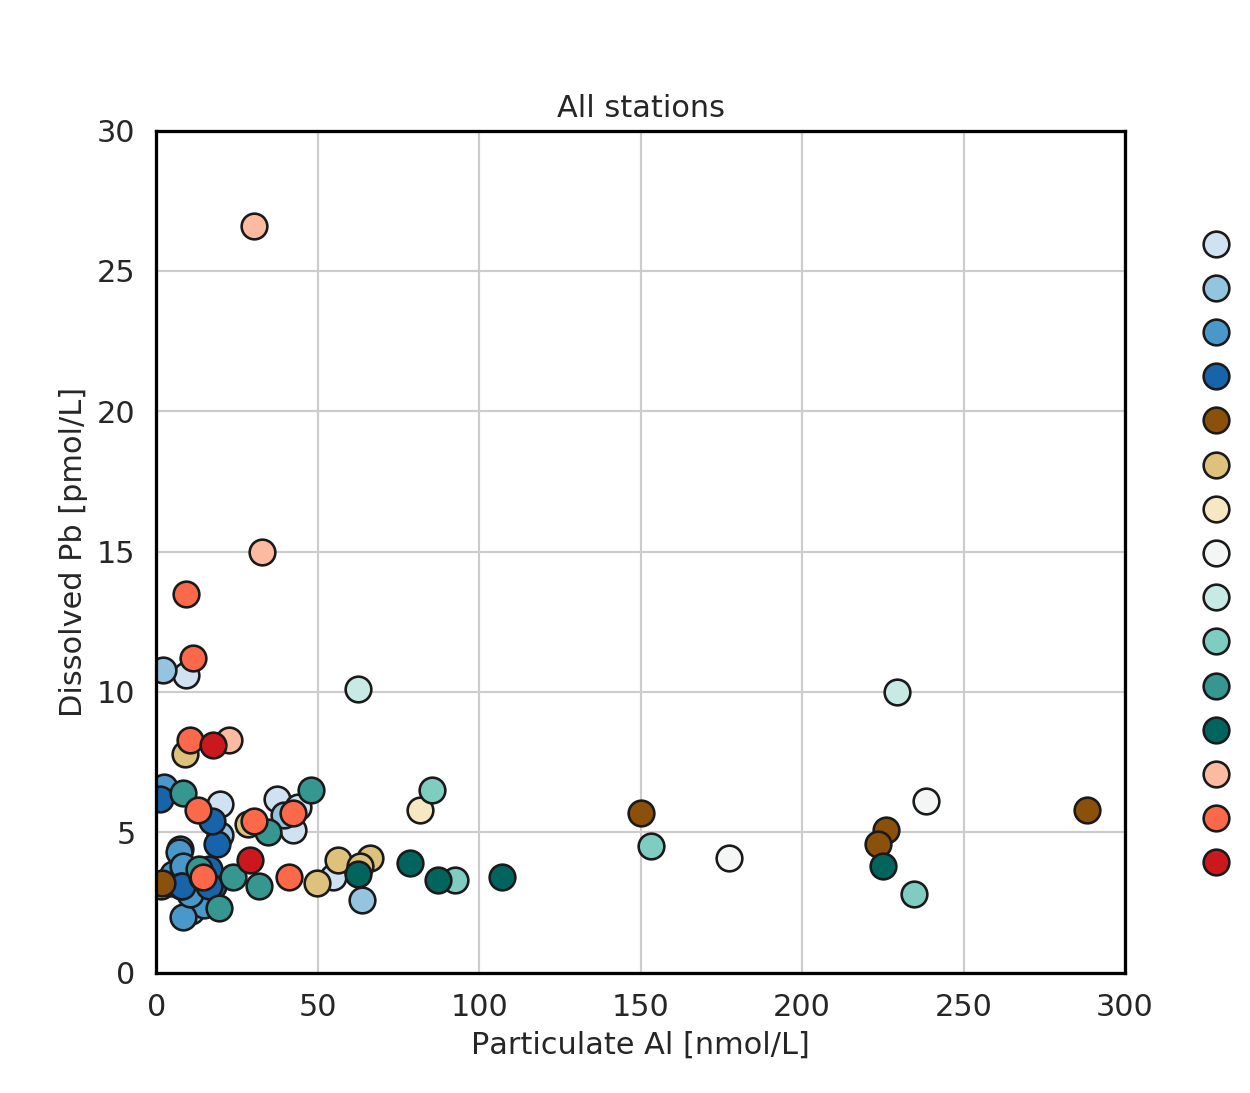

In [33]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(8,7))
    ax.set(xlim=(0,300), ylim=(0,30.0))
    
    n=0
    for station in ['CB1', 'CB2', 'CB3', 'CB4', 'CAA1', 'CAA2', 'CAA3', \
                'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9','BB1', 'BB2', 'BB3']:

        pAl_stn, dPb_stn, ddepth, b, pdepth = pair_samples(station)
        sns.scatterplot(pAl_stn[pdepth > 50], dPb_stn[pdepth > 50]*1e3, \
                        s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n], \
                        label=station)
        n+=1
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Dissolved Pb [pmol/L]', fontsize=14)
    ax.set_xlabel('Particulate Al [nmol/L]', fontsize=14)
    ax.set_title('All stations',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

<IPython.core.display.Javascript object>


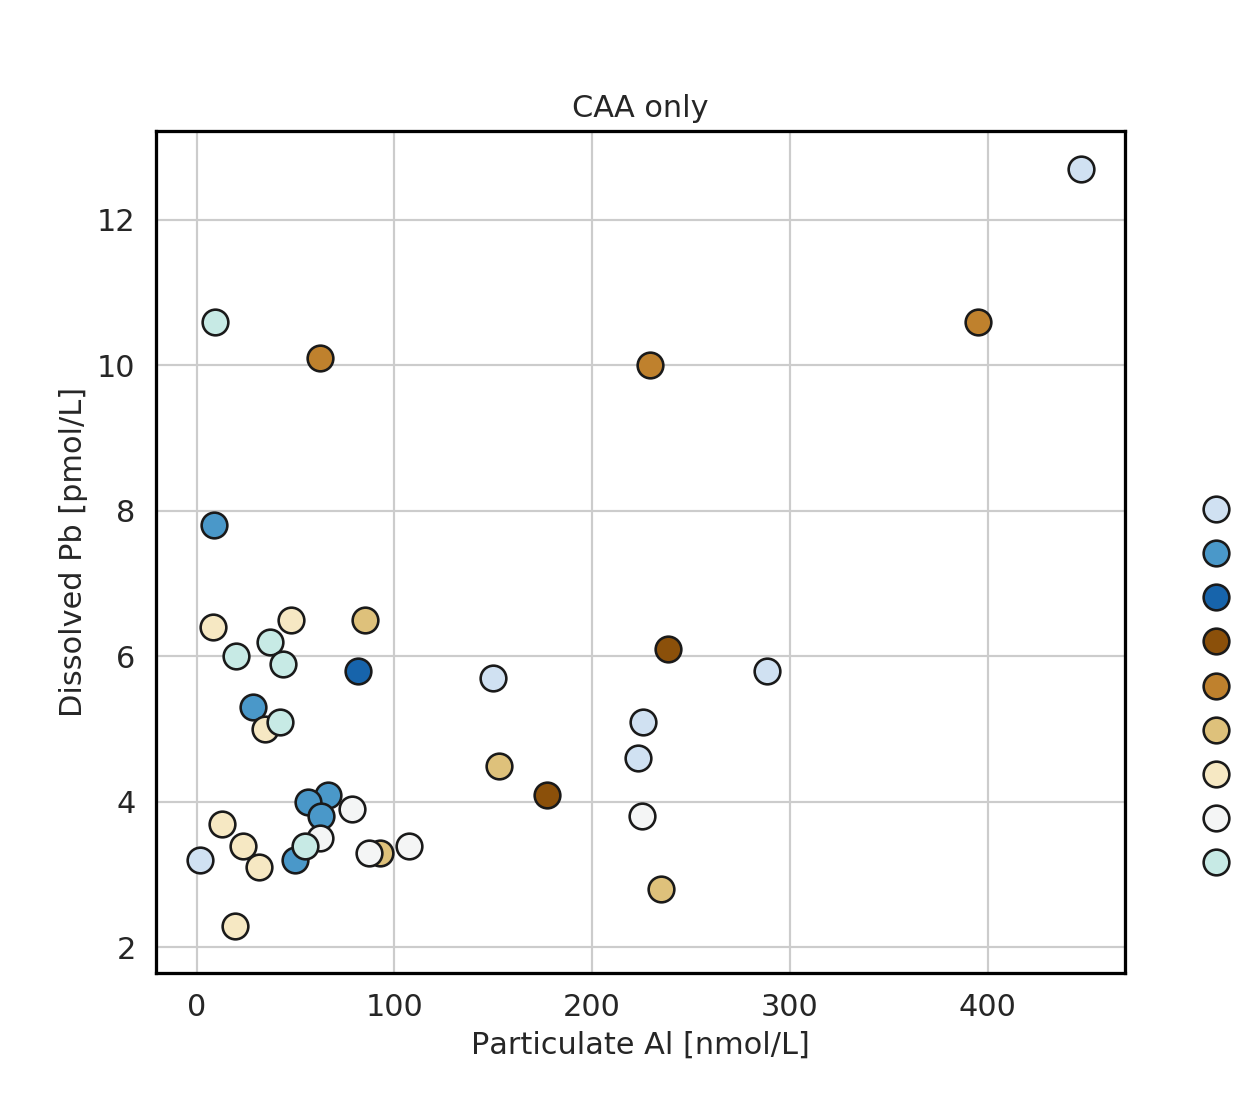

In [34]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(8,7))
#     ax.set(xlim=(0,100), ylim=(0,20))
    
    n=0
    for station in ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', 'CB1']:

        pAl_stn, dPb_stn, ddepth, b, pdepth = pair_samples(station)
        sns.scatterplot(pAl_stn[pdepth > 50], dPb_stn[pdepth > 50]*1e3, \
                        s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n], \
                        label=station)
        n+=1
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Dissolved Pb [pmol/L]', fontsize=14)
    ax.set_xlabel('Particulate Al [nmol/L]', fontsize=14)
    ax.set_title('CAA only',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

<IPython.core.display.Javascript object>


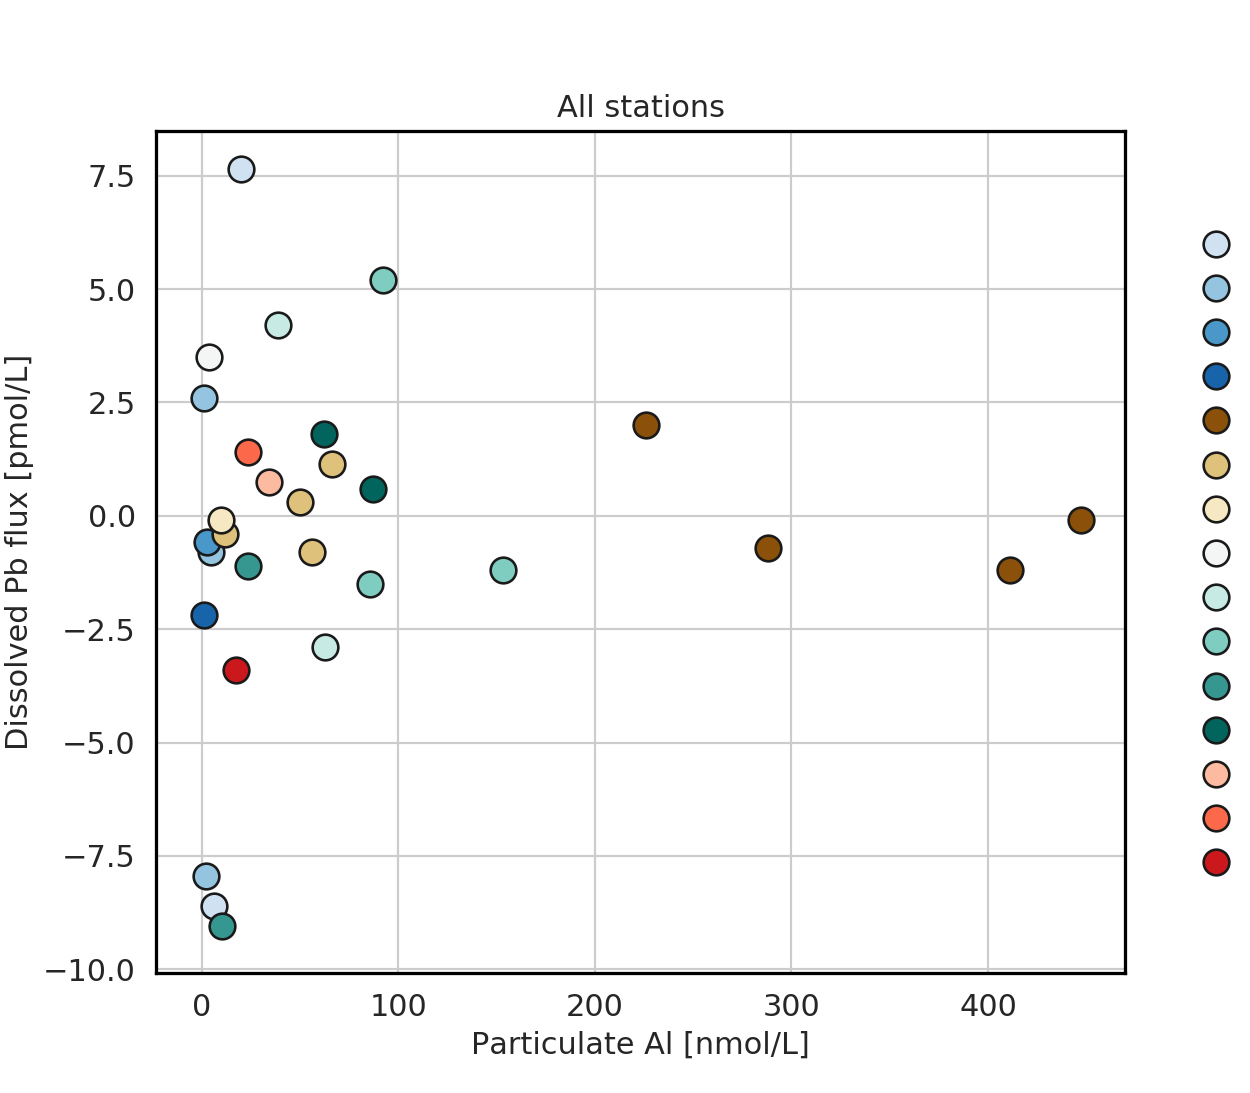

In [12]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(8,7))
#     ax.set(xlim=(0,300), ylim=(0,30.0))
    
    n=0
    for station in ['CB1', 'CB2', 'CB3', 'CB4', 'CAA1', 'CAA2', 'CAA3', \
                'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9','BB1', 'BB2', 'BB3']:
        pAl_stn, dPb_stn = pair_samples(station, chunks=True)
        sns.scatterplot(pAl_stn, np.array(dPb_stn)*1e3, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n], \
                        label=station)
        n+=1
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Dissolved Pb flux [pmol/L]', fontsize=14)
    ax.set_xlabel('Particulate Al [nmol/L]', fontsize=14)
    ax.set_title('All stations',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

<IPython.core.display.Javascript object>


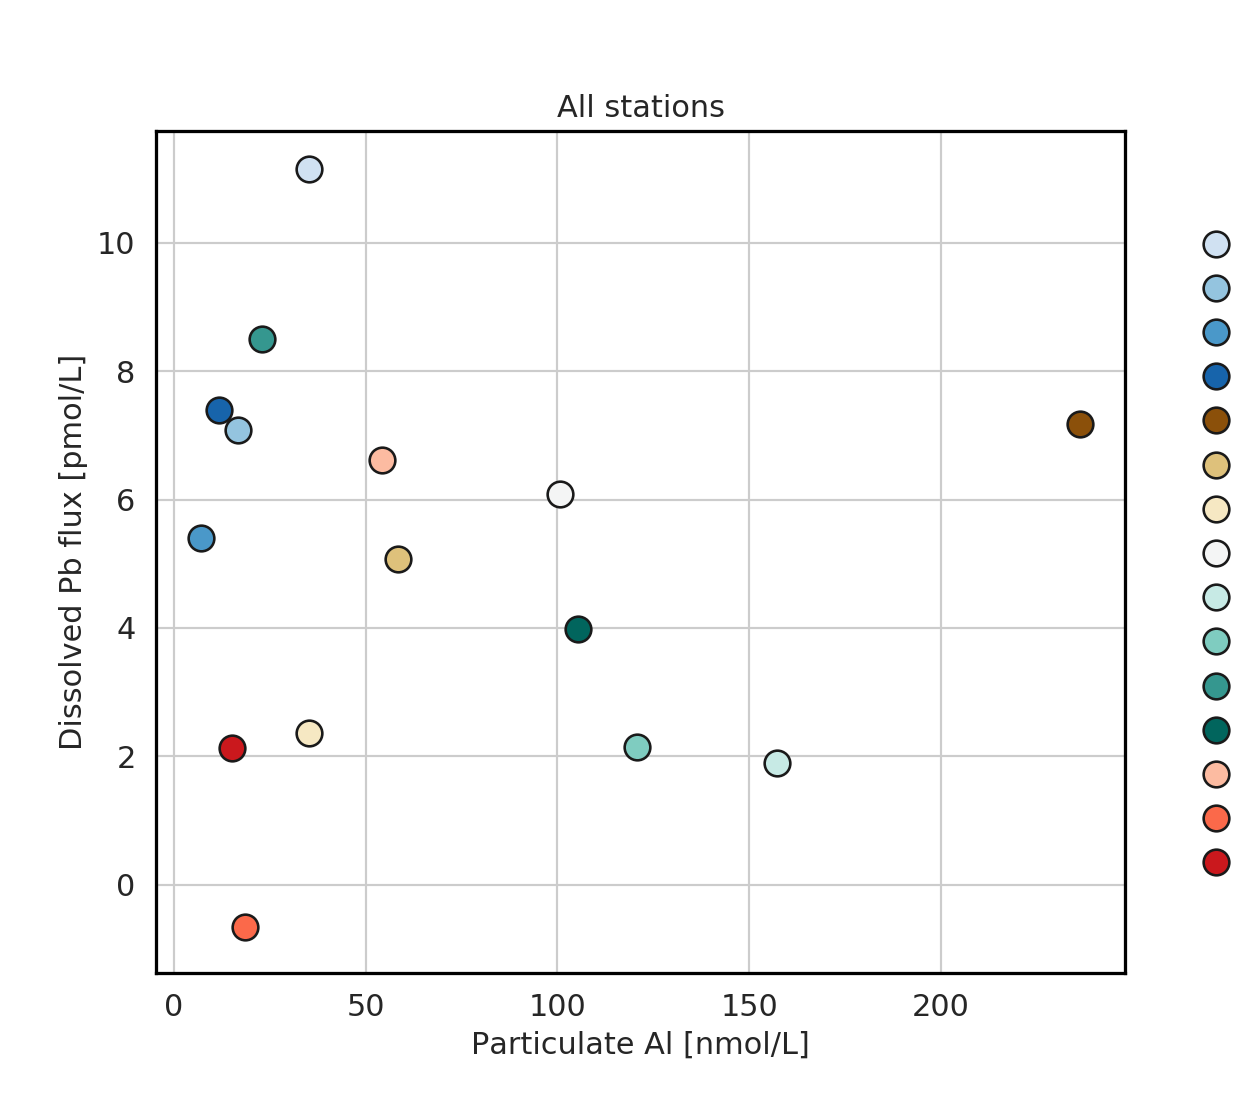

In [14]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(8,7))
#     ax.set(xlim=(0,100), ylim=(0,15))
    
    n=0
    for station in ['CB1', 'CB2', 'CB3', 'CB4', 'CAA1', 'CAA2', 'CAA3', \
                'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9','BB1', 'BB2', 'BB3']:
        pAl_stn, dPb_stn = pair_samples(station, slope=True)
        sns.scatterplot([pAl_stn], [dPb_stn*1e3], label=station, \
                        s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n])
        n+=1
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Dissolved Pb flux [pmol/L]', fontsize=14)
    ax.set_xlabel('Particulate Al [nmol/L]', fontsize=14)
    ax.set_title('All stations',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

<IPython.core.display.Javascript object>


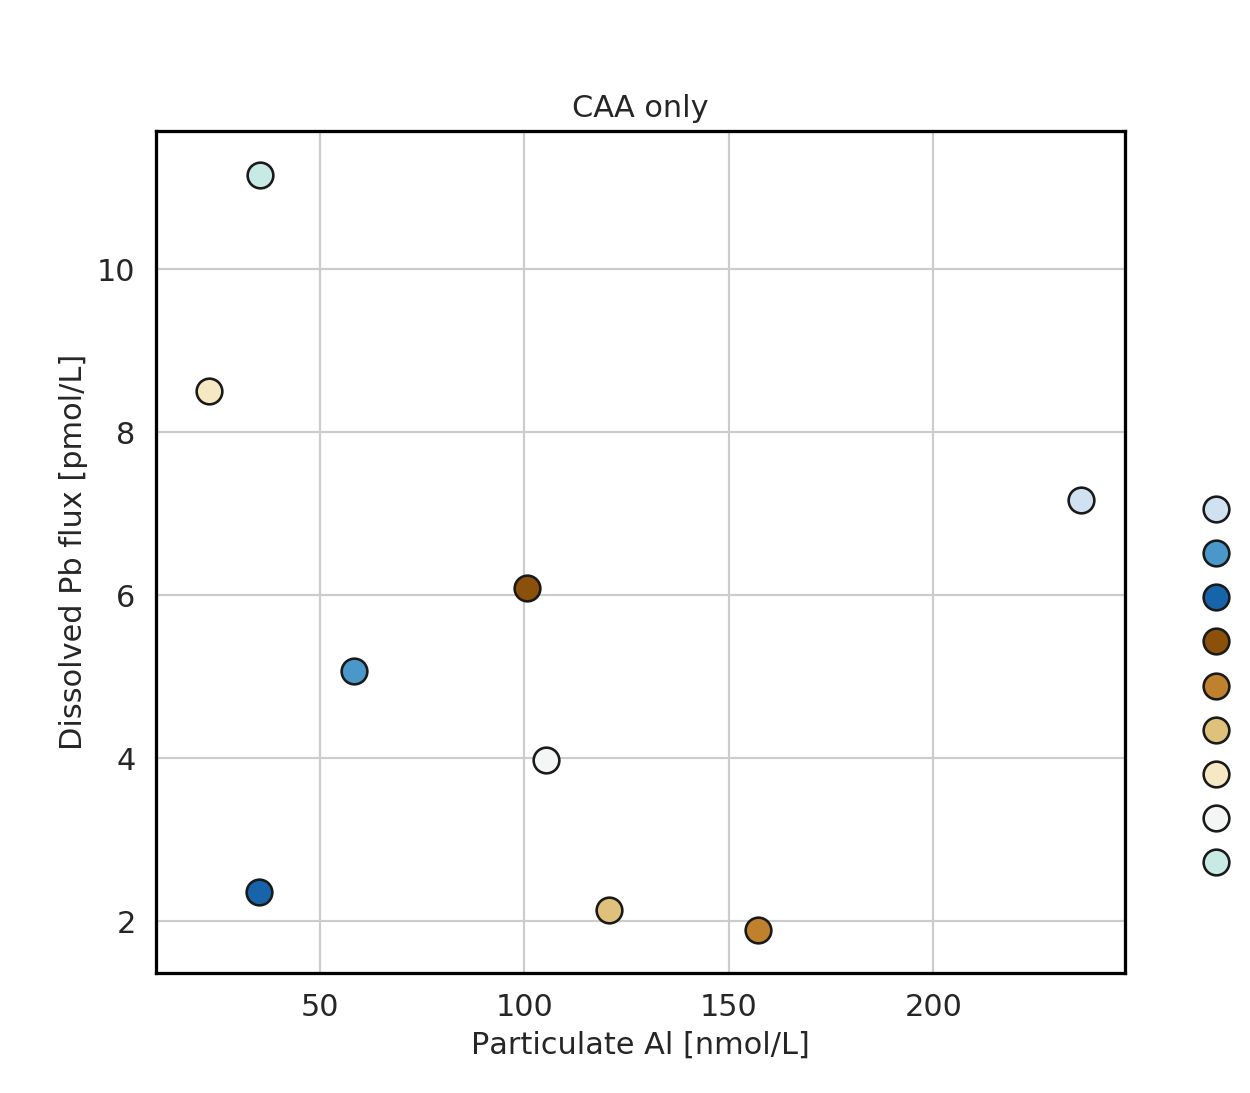

In [15]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(8,7))
#     ax.set(xlim=(0,50), ylim=(0,15))
    
    n=0
    for station in ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9','CB1']:
        pAl_stn, dPb_stn = pair_samples(station, slope=True)
        sns.scatterplot([pAl_stn], [dPb_stn*1e3], label=station, \
                        s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n])
        n+=1
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Dissolved Pb flux [pmol/L]', fontsize=14)
    ax.set_xlabel('Particulate Al [nmol/L]', fontsize=14)
    ax.set_title('CAA only',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

### Alternate idea: use a combination of pAl and POC to estimate scavenging

In [16]:
POCdata  = pd.read_csv('/ocean/brogalla/GEOTRACES/data/POC&PON_Data_GN02-GN03.csv')
POC_data = POCdata.replace(r'< LOD', 0)

In [17]:
POC_stns = [POC_data['LS2'][1:].dropna().values.astype('float'), \
            POC_data['BB1'][1:].dropna().values.astype('float'), \
            POC_data['BB2'][1:].dropna().values.astype('float'), \
            POC_data['BB3'][1:].dropna().values.astype('float'), \
            POC_data['CAA1'][1:].dropna().values.astype('float'), \
            POC_data['CAA3'][1:].dropna().values.astype('float'), \
            POC_data['CAA4'][1:].dropna().values.astype('float'), \
            POC_data['CAA5'][1:].dropna().values.astype('float'), \
            POC_data['CAA6'][1:].dropna().values.astype('float'), \
            POC_data['CAA7'][1:].dropna().values.astype('float'), \
            POC_data['CAA8'][1:].dropna().values.astype('float'), \
            POC_data['CB1'][1:].dropna().values.astype('float'), \
            POC_data['CB2'][1:].dropna().values.astype('float'), \
            POC_data['CB3'][1:].dropna().values.astype('float'), \
            POC_data['CB4'][1:].dropna().values.astype('float')]

depths_POC = [POC_data['Depth.1'][1:].dropna().values.astype('float'), \
              POC_data['Depth.2'][1:].dropna().values.astype('float'), \
              POC_data['Depth.3'][1:].dropna().values.astype('float'), \
              POC_data['Depth.4'][1:].dropna().values.astype('float'), \
              POC_data['Depth.5'][1:].dropna().values.astype('float'),\
              POC_data['Depth.6'][1:].dropna().values.astype('float'), \
              POC_data['Depth.7'][1:].dropna().values.astype('float'), \
              POC_data['Depth.8'][1:].dropna().values.astype('float'), \
              POC_data['Depth.9'][1:].dropna().values.astype('float'), \
              POC_data['Depth.10'][1:].dropna().values.astype('float'), \
              POC_data['Depth.11'][1:].dropna().values.astype('float'), \
              POC_data['Depth.12'][1:].dropna().values.astype('float'), \
              POC_data['Depth.13'][1:].dropna().values.astype('float'), \
              POC_data['Depth.14'][1:].dropna().values.astype('float'), \
              POC_data['Depth.15'][1:].dropna().values.astype('float')]

POC_names = np.concatenate((['LS2' for i in POC_data['LS2'][1:].dropna()], \
                            ['BB1' for i in POC_data['BB1'][1:].dropna()], \
                            ['BB2' for i in POC_data['BB2'][1:].dropna()], \
                            ['BB3' for i in POC_data['BB3'][1:].dropna()], \
                            ['CAA1' for i in POC_data['CAA1'][1:].dropna()], \
                            ['CAA3' for i in POC_data['CAA3'][1:].dropna()], \
                            ['CAA4' for i in POC_data['CAA4'][1:].dropna()], \
                            ['CAA5' for i in POC_data['CAA5'][1:].dropna()], \
                            ['CAA6' for i in POC_data['CAA6'][1:].dropna()], \
                            ['CAA7' for i in POC_data['CAA7'][1:].dropna()], \
                            ['CAA8' for i in POC_data['CAA8'][1:].dropna()], \
                            ['CB1' for i in POC_data['CB1'][1:].dropna()], \
                            ['CB2' for i in POC_data['CB2'][1:].dropna()], \
                            ['CB3' for i in POC_data['CB3'][1:].dropna()], \
                            ['CB4' for i in POC_data['CB4'][1:].dropna()]))

POC_depths = np.concatenate(depths_POC).ravel()
POC_observ = np.concatenate(POC_stns).ravel()

In [18]:
POC_BB1 = POC_stns[1];   POC_BB2 = POC_stns[2];  POC_BB3 = POC_stns[3];
POC_CAA1 = POC_stns[4];  POC_CAA3 = POC_stns[5]; POC_CAA4 = POC_stns[6];
POC_CAA5 = POC_stns[7];  POC_CAA6 = POC_stns[8]; POC_CAA7 = POC_stns[9];
POC_CAA8 = POC_stns[10]; POC_CB1 = POC_stns[11]; POC_CB2 = POC_stns[12];
POC_CB3 = POC_stns[13];  POC_CB4 = POC_stns[14];

depth_POC_BB1  = depths_POC[1];   depth_POC_BB2  = depths_POC[2];  depth_POC_BB3  = depths_POC[3];
depth_POC_CAA1 = depths_POC[4];   depth_POC_CAA3 = depths_POC[5];  depth_POC_CAA4 = depths_POC[6];
depth_POC_CAA5 = depths_POC[7];   depth_POC_CAA6 = depths_POC[8];  depth_POC_CAA7 = depths_POC[9];
depth_POC_CAA8 = depths_POC[10];  depth_POC_CB1  = depths_POC[11]; depth_POC_CB2  = depths_POC[12];
depth_POC_CB3  = depths_POC[13];  depth_POC_CB4  = depths_POC[14];

<IPython.core.display.Javascript object>


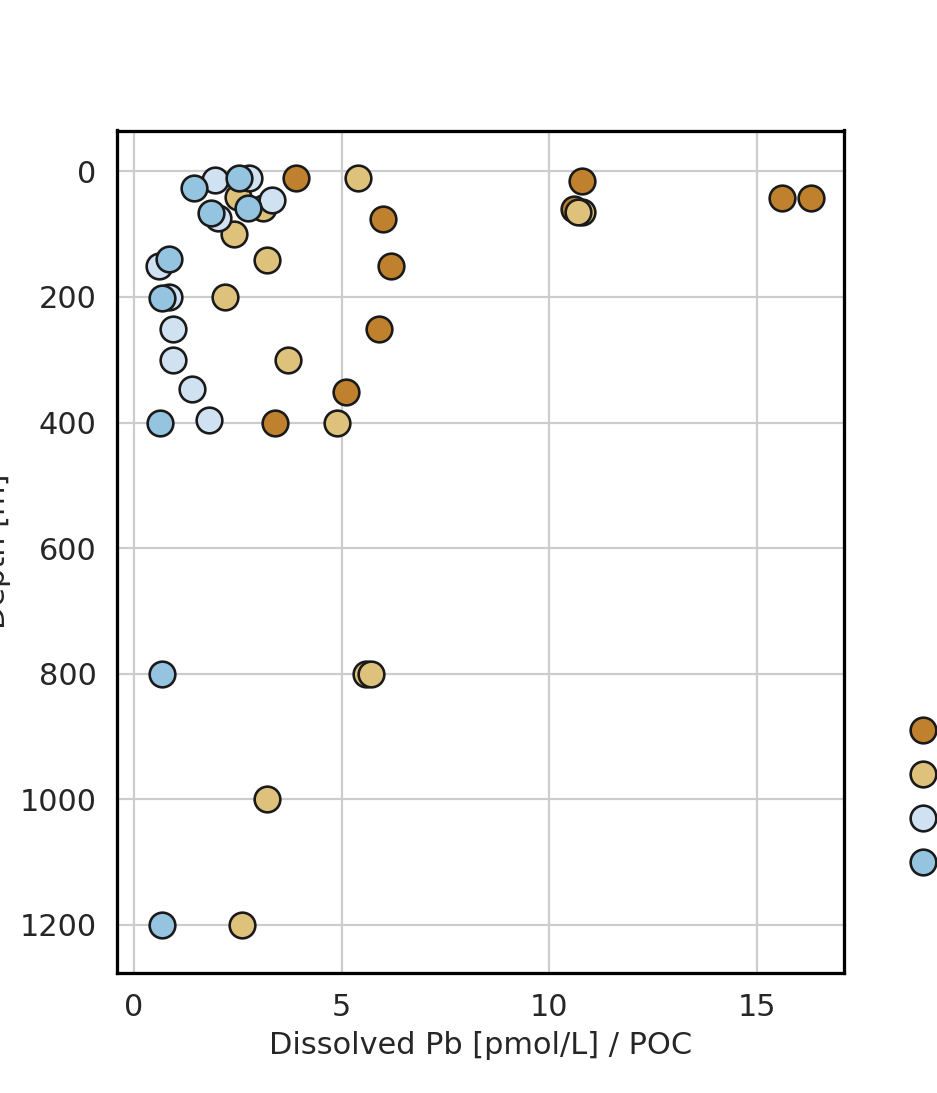

In [23]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,7))
#     ax.set(xlim=(0,300), ylim=(0,30.0))
    ax.invert_yaxis()

    n=0    
    for station in ['CB1', 'CB2']:#, 'CB3', 'CB4']:
        pAl_stn, dPb_stn, ddep, dPb_full = pair_samples(station)
        sns.scatterplot(dPb_full*1e3, ddep, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n+5], \
                        label=station)
        n+=1        
    sns.scatterplot(POC_CB1, depth_POC_CB1, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1-POC')
    sns.scatterplot(POC_CB2, depth_POC_CB2, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2-POC')
#     sns.scatterplot(POC_CB3, depth_POC_CB3, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2])
#     sns.scatterplot(POC_CB4, depth_POC_CB4, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3])
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Depth [m]', fontsize=14)
    ax.set_xlabel('Dissolved Pb [pmol/L] / POC', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

In [ ]:
POC = nc.Dataset('/ocean/brogalla/GEOTRACES/data/b.e11.B1850C5CN.f09_g16.005.pop.h.POC_FLUX_IN.200001-209912.nc')
POC_lon  = np.array(POC.variables['TLONG'])
POC_lat  = np.array(POC.variables['TLAT'])
POC_dep  = np.array(POC.variables['z_t'])*1e-2    # depth from surface (cm)
POC_time = np.array(POC.variables['time'])        # days since 0000-01-01 00:00:00, noleap
POC_flux = np.array(POC.variables['POC_FLUX_IN']) # mmol /m3 cm/s